# Анализ бизнес-показателей развлекательного приложения

**Цели исследования:** Разобраться в причинах убытков компании в последние несколько месяцев и дать рекомендации по улучшению ситуации.

**В наличие следующие данные:**
- лог сервера с информацией о посещениях сайта;
- информация о заказах;
- информация о расходах на рекламу.

**Ход исследования:**
- Обзор данных
- Предобработка данных
- Исследовательский анализ данных
- Проверяем гипотезы
- Общий вывод и рекомендации

**Оглавление**
1. Обзор данных
2. Предобработка
3. Задаем функции для расчета параметров
4. Исследовательский анализ
5. Маркетинг
6. Оценка окупаемости рекламы
7. Гипотезы и их проверка
8. Общий вывод и рекомендации

### Обзор данных

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

#### Проверка датасетов и их предобработка

#### ВЫВОД

В данных были исправлены названия колонок, изменены форматы. Явных или неявных дубликатов невыявленно. Пропусков нет. 

Общий итог:
- 4 страны
- 4 типа устройств
- 11 источников прихода клиентов
- 10 рекламных источников
- Период посещений с 01.05.2019г. по 31.10.2019г.
- Период совершения покупок с 01.05.2019г. по 31.10.2019г.
- Дата проведения рекламных компаний с 01.05.2019г. по 27.10.2019г.
- Уникальных пользователей user_id - 150008
- Уникальных пользователей совершивших покупку user_id - 8881

### Задаем функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Исследовательский анализ данных

#### Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.

In [ ]:
profiles = get_profiles(visits, orders, costs)

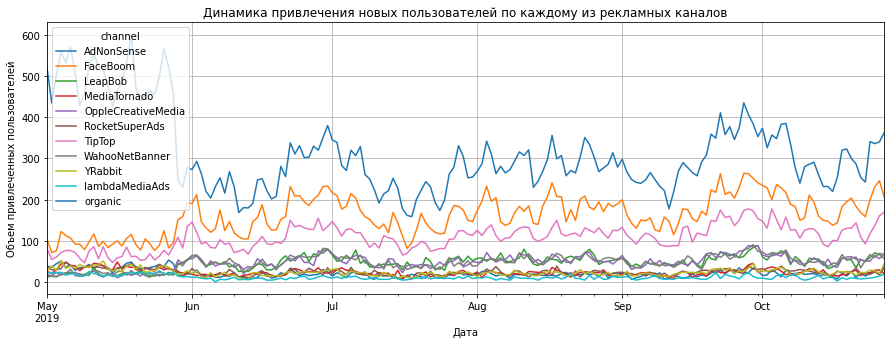

In [ ]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.title("Динамика привлечения новых пользователей по каждому из рекламных каналов")
plt.xlabel('Дата')
plt.ylabel('Объем привлеченных пользователей')

plt.show()

In [ ]:
min(profiles['dt'])

Timestamp('2019-05-01 00:00:00')

In [ ]:
max(profiles['dt'])

Timestamp('2019-10-27 00:00:00')

##### Вывод

Самые **популярные** источники посетителей:
- `organic`
- `FaceBoom`
- `TipTop`

Самые **не популярные** источники посетителей:
- `lambdaMediaAds`
- `AdNonSense`
- `MediaTornado`
- `YRabbit`
- `RocketSuperAds`

С начала мая виден сильный отрыв источника `organic`. Привлечений больше в 4-6 раз от ближайшего конкурента. Однако с конца мая видно резкое двукратное падание.

Минимальная дата привлечения пользователей - 01.05.2019

Максимальная дата привлечения пользователей - 27.10.2019

#### Страна из которой пользователи приходят в приложение чаще и на какую страну приходится больше всего платящих пользователей.

In [ ]:
profiles.sample(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
9249,61830591148,2019-08-01 17:48:33,organic,Mac,United States,2019-08-01,2019-08-01,False,0.000000
26902,179329551685,2019-07-08 20:08:48,FaceBoom,Mac,United States,2019-07-08,2019-07-01,False,1.127673
6333,42397117772,2019-06-12 18:08:48,FaceBoom,Android,United States,2019-06-12,2019-06-01,False,1.131429
78545,521166855742,2019-10-17 01:37:26,organic,Android,Germany,2019-10-17,2019-10-01,False,0.000000
10422,69376745615,2019-09-17 13:01:51,MediaTornado,Android,United States,2019-09-17,2019-09-01,False,0.200000


In [ ]:
ru = profiles.groupby('region').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [ ]:
ru.columns = ['region', 'number_of_users']

In [ ]:
rpu = (
    profiles
    .query('payer == True')
    .groupby('region')
    .agg({'user_id': 'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

In [ ]:
rpu.columns = ['region', 'number_of_payer_users']

In [ ]:
rpu['percent'] = round(rpu['number_of_payer_users'] / rpu['number_of_payer_users'].sum() * 100, 2)

In [ ]:
ru = ru.merge(rpu[['region', 'number_of_payer_users']], on='region')

In [ ]:
ru['percent'] = round(ru['number_of_payer_users'] / ru['number_of_users'] * 100, 2)

##### Вывод

Большего всего пользователей приходит из `USA`, 100т пользователей из 150т.

Больше всего пользователей которые совершили покупку приходят из `USA`, 6902 пользователей из 8881, что составляет 77,72%.

Процент платящих пользователей от общего количества пользователей этой страны больше всего у `USA` - 6.9 %

#### Устройства, которыми пользуются клиенты и какие устройства предпочитают платящие пользователи

In [ ]:
du = profiles.groupby('device').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [ ]:
du.columns = ['device', 'number_of_users']

In [ ]:
du

,device,number_of_users
3,iPhone,54479
0,Android,35032
2,PC,30455
1,Mac,30042


In [ ]:
dpu = (
    profiles
    .query('payer == True')
    .groupby('device')
    .agg({'user_id': 'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

In [ ]:
dpu.columns = ['device', 'number_of_payer_users']

In [ ]:
dpu['percent'] = round(dpu['number_of_payer_users'] / dpu['number_of_payer_users'].sum() * 100, 2)

In [ ]:
dpu

,device,number_of_payer_users,percent
3,iPhone,3382,38.08
0,Android,2050,23.08
1,Mac,1912,21.53
2,PC,1537,17.31


In [ ]:
du = du.merge(dpu[['device', 'number_of_payer_users']], on='device')

In [ ]:
du['payer_percent'] = round(du['number_of_payer_users'] / du['number_of_users'] * 100, 2)

In [ ]:
du

,device,number_of_users,number_of_payer_users,payer_percent
0,iPhone,54479,3382,6.21
1,Android,35032,2050,5.85
2,PC,30455,1537,5.05
3,Mac,30042,1912,6.36


##### Вывод

Большего всего пользователей используют `iPhone` , 54т пользователей из 150т.

Больше всего пользователей, которые совершили покупку, используют `iPhone`, 3382 пользователей из 8881, что составляет 38%.

Процент платящих пользователей от общего количества пользователей этого устройства больше всего у `iPhone` - 6.21 %

#### Рекламные источники привлечения и  каналы, из которых пришло больше всего платящих пользователей

In [ ]:
cu = profiles.groupby('channel').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [ ]:
cu.columns = ['channel', 'number_of_users']

In [ ]:
cu

,channel,number_of_users
10,organic,56439
1,FaceBoom,29144
6,TipTop,19561
4,OppleCreativeMedia,8605
2,LeapBob,8553
7,WahooNetBanner,8553
5,RocketSuperAds,4448
3,MediaTornado,4364
8,YRabbit,4312
0,AdNonSense,3880


In [ ]:
cpu = (
    profiles
    .query('payer == True')
    .groupby('channel')
    .agg({'user_id': 'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

In [ ]:
cpu.columns = ['channel', 'number_of_payer_users']

In [ ]:
cpu['payer_percent'] = round(cpu['number_of_payer_users'] / cpu['number_of_payer_users'].sum() * 100, 2)

In [ ]:
cpu

,channel,number_of_payer_users,payer_percent
1,FaceBoom,3557,40.05
6,TipTop,1878,21.15
10,organic,1160,13.06
7,WahooNetBanner,453,5.10
0,AdNonSense,440,4.95
5,RocketSuperAds,352,3.96
2,LeapBob,262,2.95
4,OppleCreativeMedia,233,2.62
9,lambdaMediaAds,225,2.53
8,YRabbit,165,1.86


In [ ]:
cu = cu.merge(cpu[['channel', 'number_of_payer_users']], on='channel')

In [ ]:
cu['payer_percent'] = round(cu['number_of_payer_users'] / cu['number_of_users'] * 100, 2)

In [ ]:
cu.sort_values(by='payer_percent', ascending=False)

,channel,number_of_users,number_of_payer_users,payer_percent
1,FaceBoom,29144,3557,12.20
9,AdNonSense,3880,440,11.34
10,lambdaMediaAds,2149,225,10.47
2,TipTop,19561,1878,9.60
6,RocketSuperAds,4448,352,7.91
5,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
7,MediaTornado,4364,156,3.57
4,LeapBob,8553,262,3.06
3,OppleCreativeMedia,8605,233,2.71


##### Вывод

Большего всего пользователей пришло по каналу `organic` , 56т пользователей из 150т.

Больше всего пользователей, которые совершили покупку, пришло по каналу `FaceBoom` , 3557 пользователей из 8881, что составляет 40%
 
Процент платящих пользователей от общего количества пользователей по каналу привлечения больше всего у `FaceBoom` - 12.20%

Процент платящих пользователей от общего количества пользователей по каналу привлечения хуже всего у `organic` - 2.06%

#### ВЫВОД

Целевая аудитория данного развлекательного приложения в основном из `USA`, в других странах данное приложение представленно в несколько раз хуже. Основным устройством использования приложения является `iPhone`, но и на другие устройства приходится внушительная аудитория. Основным каналом привлекающими платящих клиентов является `FaceBoom`, однако присутствуют каналы, которые при меньшем объеме привлекаемых клиентов, в процентном соотношение привлекают почти столько же платящих клиентов (`AdNonSense`, `lambdaMediaAds`, `TipTop`). Органический канал на третьем месте по объему привлеченных платящих клиентов, хоть и с самой худшим процентом относительного общего объема привлеченных клиентов.

### Маркетинг

#### Общая сумма расходов на рекламу. Разбивка расходов по источикам

In [ ]:
costs.sample(2)

,dt,channel,costs,month,week
767,2019-06-17,YRabbit,2.88,2019-06-01,2019-06-13
39,2019-06-09,FaceBoom,163.90,2019-06-01,2019-06-06


In [ ]:
costs['costs'].sum()

105497.30000000002

In [ ]:
costs.groupby('channel')['costs'].sum().reset_index().sort_values(by='costs', ascending=False)

,channel,costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


##### ВЫВОД 

Больше всего денег потрачено на привлечение по двум каналам:
- `TipTop`
- `FaceBoom`

#### Визуализация динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику

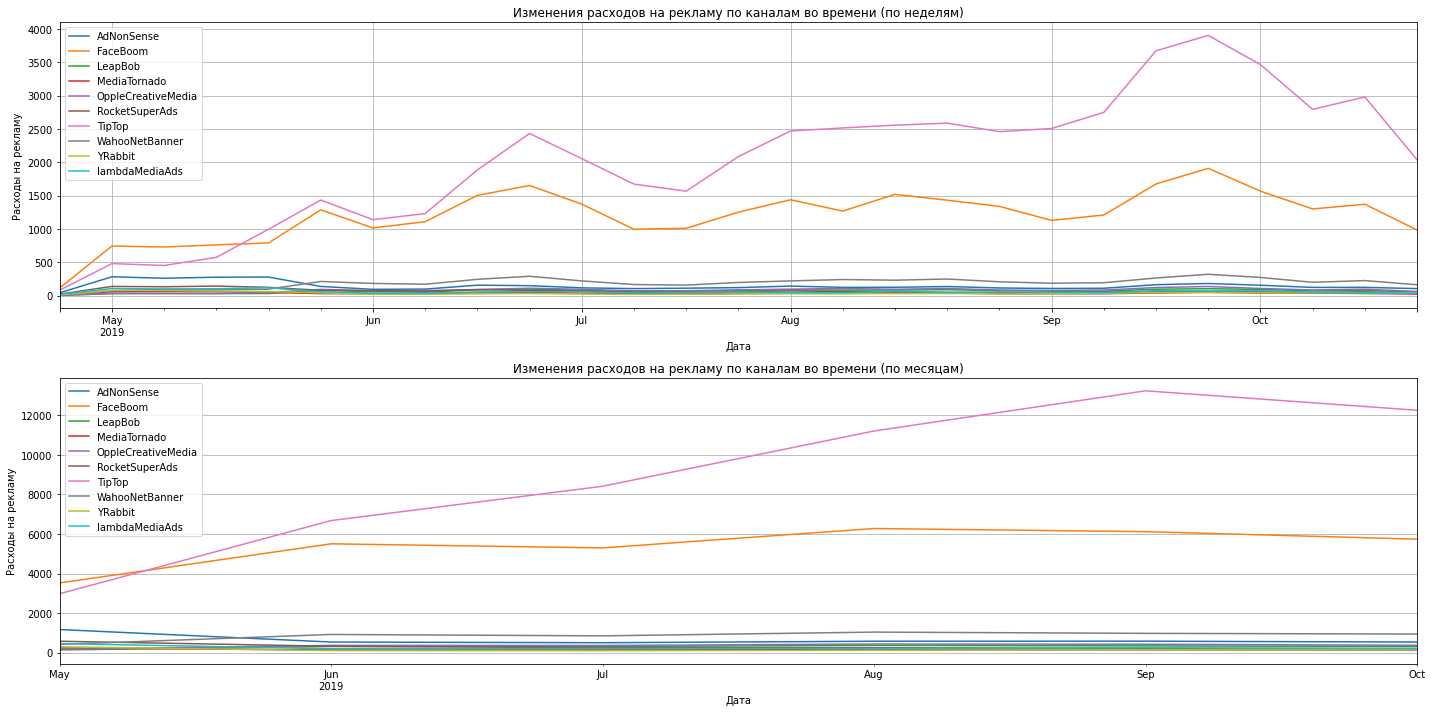

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2, 1, 1)
costs.pivot_table(
    index='week',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Расходы на рекламу')
plt.title('Изменения расходов на рекламу по каналам во времени (по неделям)')

ax2 = plt.subplot(2, 1, 2)
costs.pivot_table(
    index='month',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Расходы на рекламу')
plt.title('Изменения расходов на рекламу по каналам во времени (по месяцам)')
fig.tight_layout()

plt.show()

##### ВЫВОД 

Затраты на привлечение по каналам `TipTop` и `FaceBoom` увеличивались ежемесячно, с последней недели сентября наметилась тенденция со снижением расходов по этим каналам. По остальным каналам расходжы были стабильно низкими и без скачков.

#### Cколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [ ]:
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False).reset_index()

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


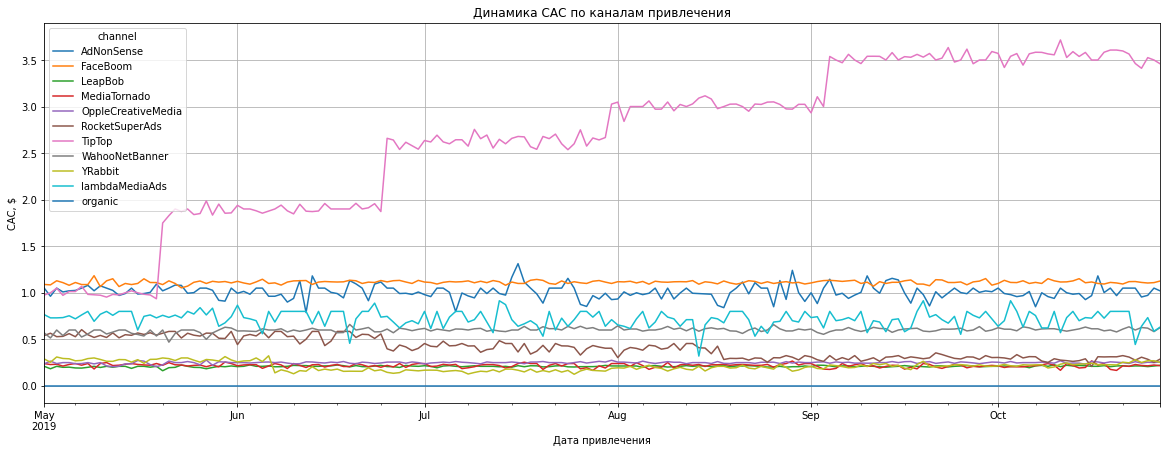

In [ ]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 7))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

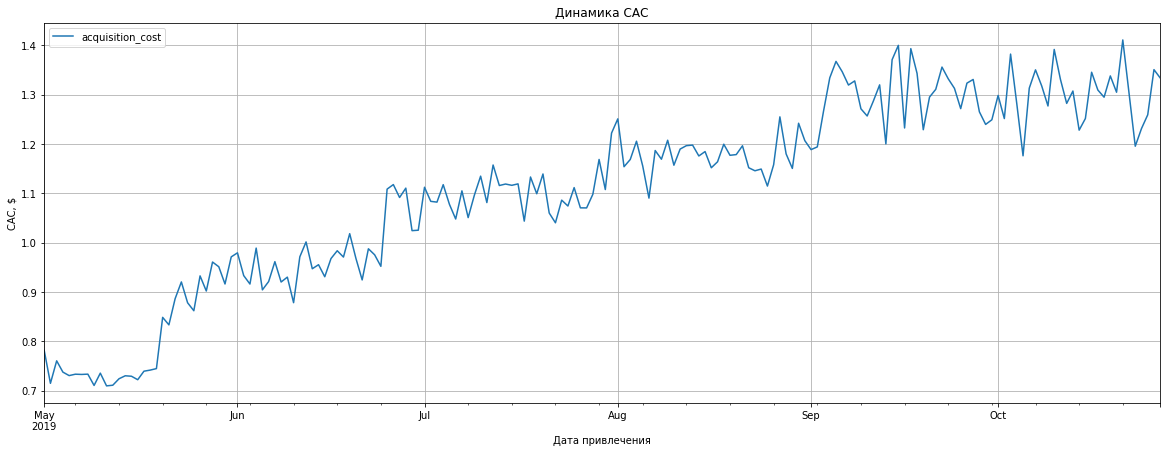

In [ ]:
profiles.pivot_table(
    index='dt', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 7))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС')
plt.show()

##### ВЫВОД 

Все каналы привлечения, кроме `TipTop` имеет стабильную среднюю стоимость привлечения нового клиента, без сильных отклонений. По каналу `TipTop` виден рост средней стоимости привлечения нового клиента, с 4 резкими скачками роста. Из общего графика видно, что канал `TipTop` сильно влияет на общую динамику средней стоимости привлечения нового клиента.

### Оценка окупаемости рекламы

#### Исключение органических пользователей

При оценке окупаемости рекламных компаний, считаю неоходимым исключить из данных канал organic, по причине того, что по этому каналу пришло 13% платящих пользователей, что исказит данные об окупаемости рекламы.

In [ ]:
profiles = profiles.query('channel != "organic"')

#### Окупаемость рекламы на графиках LTV и ROI, а также графики динамики LTV, CAC и ROI

Установим горизонт анализа данных, равный 14 дням, а момент анализа - 30.09.2019г.

In [ ]:
horizon_days = 14
observation_date = datetime(2019, 11, 1).date()

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

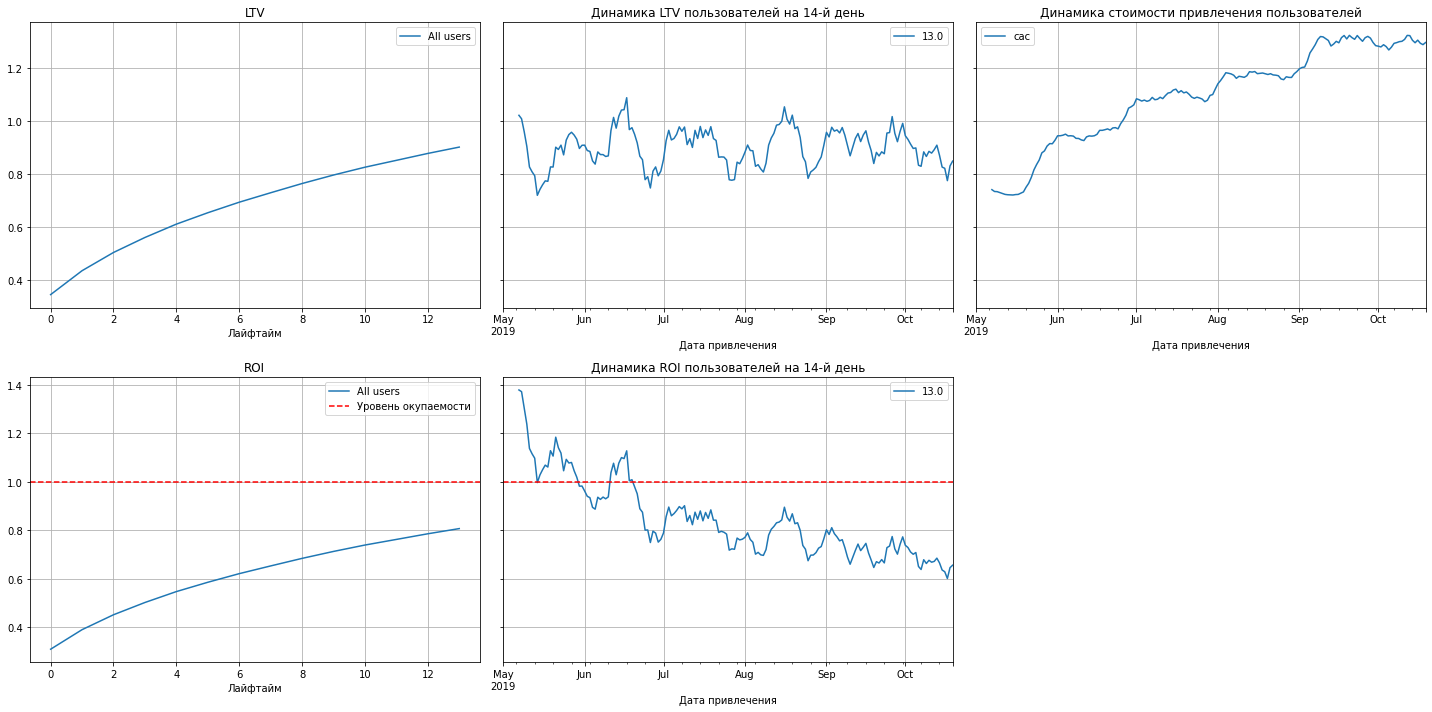

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

##### ВЫВОД

Из представленных выше графиков можно сделать следующие выводы:
- С мая идет постепенный рост стоимости привлечения одного клиента (CAC);
- Реклама не окупается. ROI в конце второй недели — чуть выше 80%;
- Начиная с середины июня динамика ROI пользователей на 14-й день перестала окупаться;
- LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

#### Конверсия пользователей и динамика её изменения

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, 
    orders, 
    observation_date,
    horizon_days,    
)

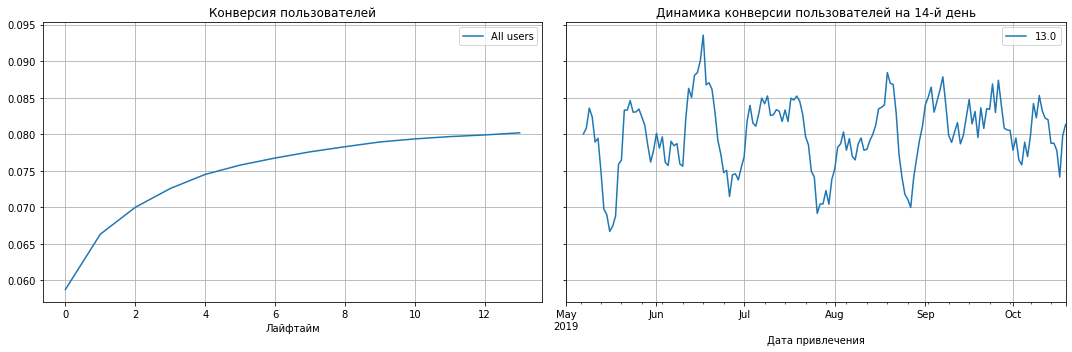

In [ ]:
plot_conversion(conversion, conversion_history, horizon_days, window=7)

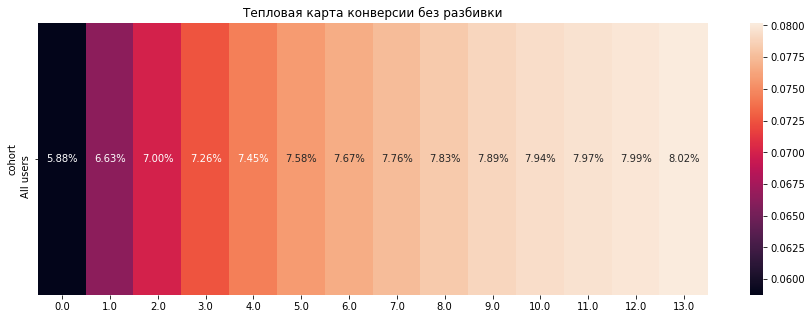

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии без разбивки')
plt.show() 

##### ВЫВОД

Общая конверсия растёт: от 5,88% в первый день «жизни» пользователей до 8,02% на четырнадцатый день. На графике 14-ого дня видно, что с мая по сентябрь присутствует высокая волатильность, а с сентября заметно явное уменьшение волатильности.

#### Удержание пользователей и динамика изменений

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
)

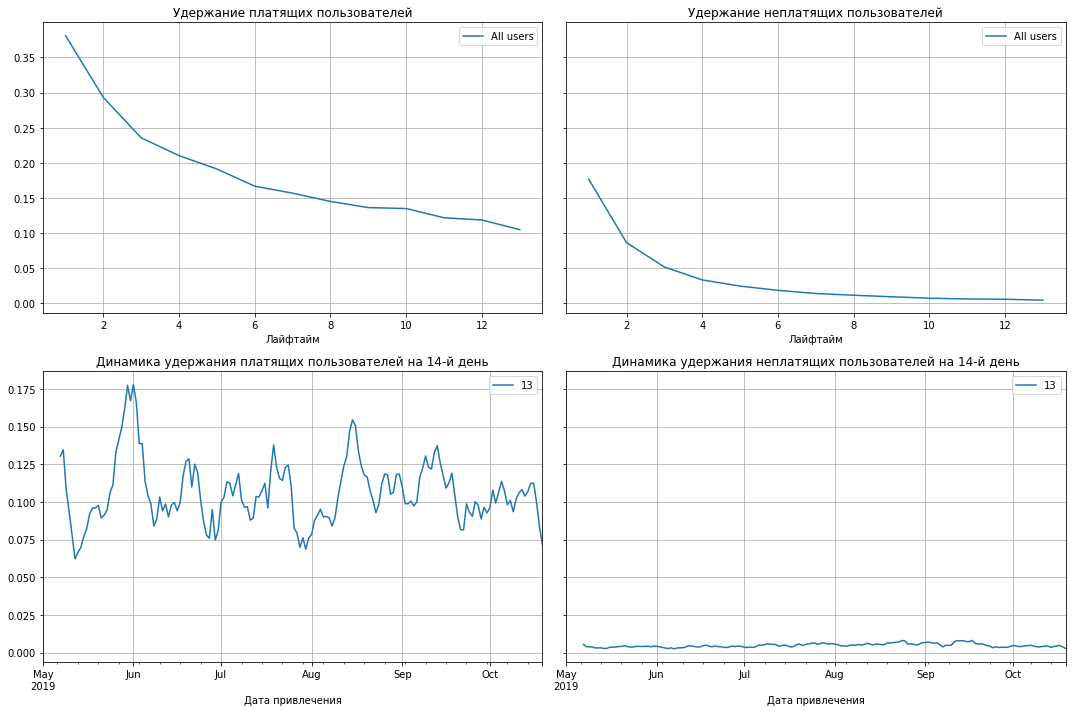

In [ ]:
plot_retention(retention, retention_history, horizon_days, window=7)

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'],
    
)

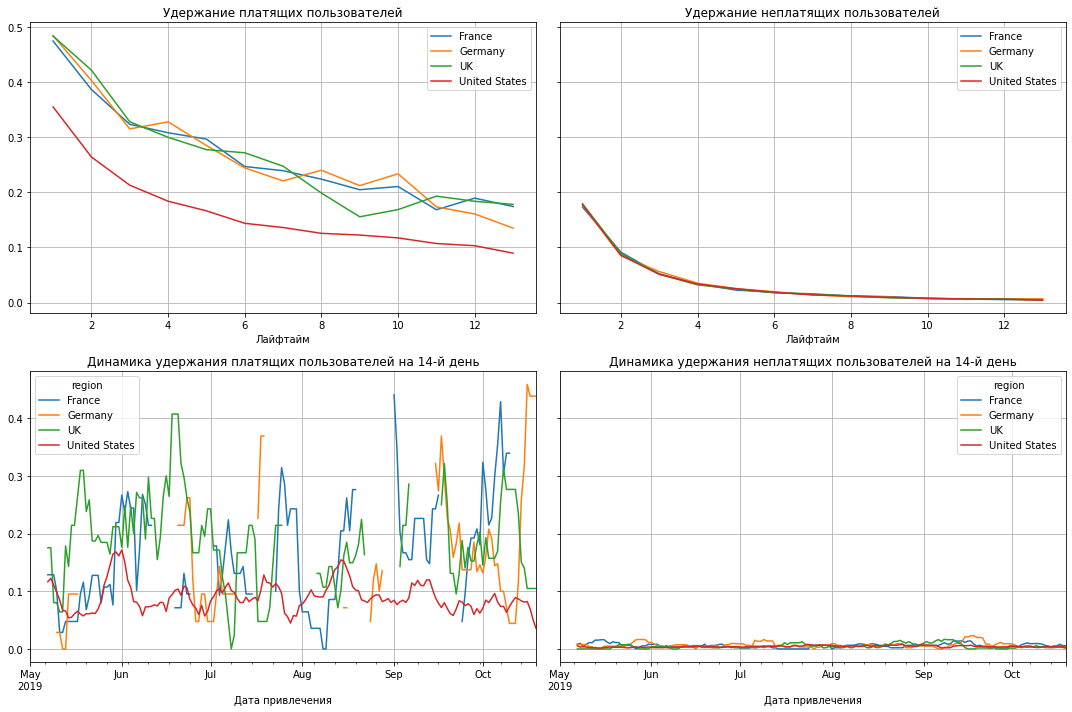

In [ ]:
plot_retention(retention, retention_history, horizon_days, window=7)

##### ВЫВОД

Удеражание платящих клиентов лучше, чем не платящих. В USA удержание платящих пользователей хуже всего.

#### Анализ окупаемости рекламы с разбивкой по устройствам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['device'])

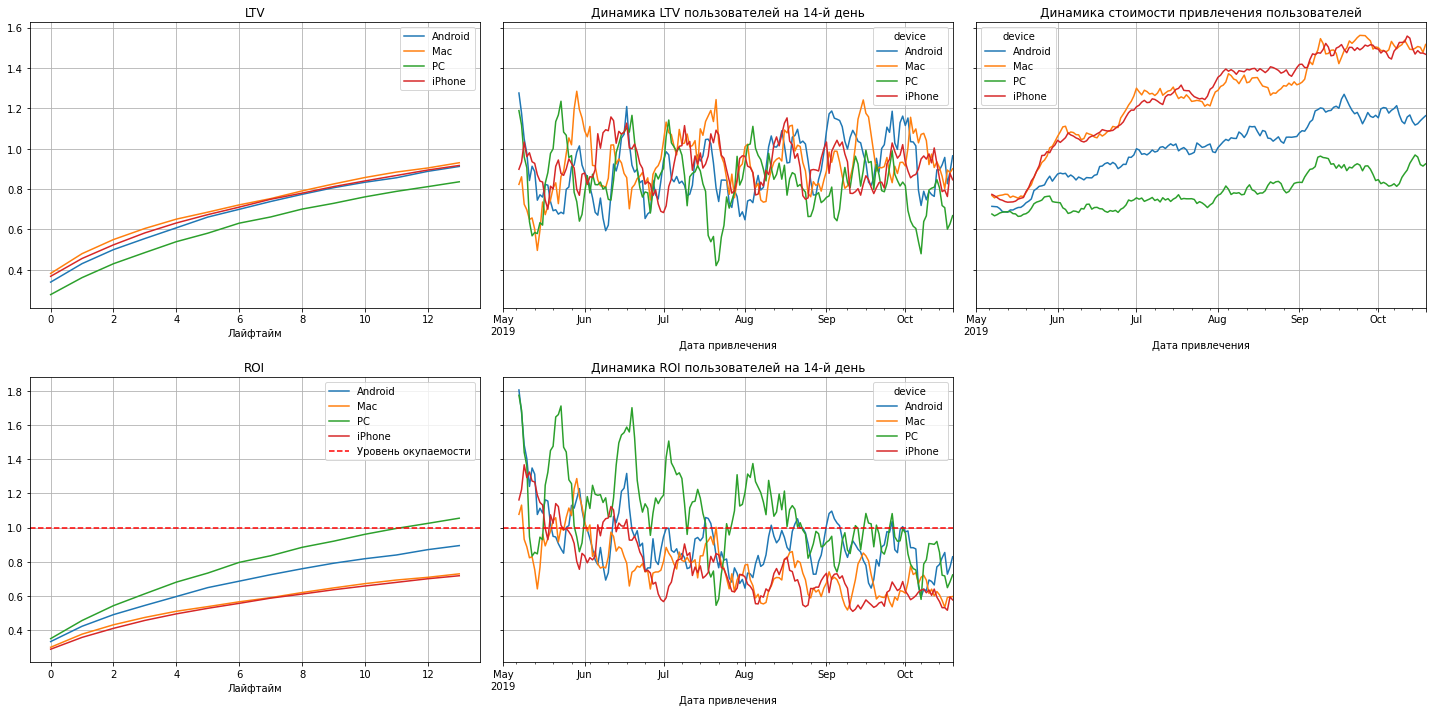

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

##### ВЫВОД

В разбивке по устройством можно сделать следующие выводы:
- Реклама окупается только на PC, с 11-ого дня. На остальных устройствах реклама не окупается вообще.
- Стоимость привлечения стабильно растет для всех устройств. Для устройств iPhone и Mac рост составил около 100%, самый слабый рост на PC.
- LTV стабилен, хуже всего для PC, явных аутсайдеров и лидеров нет.

#### Анализ окупаемости рекламы с разбивкой по странам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['region'])

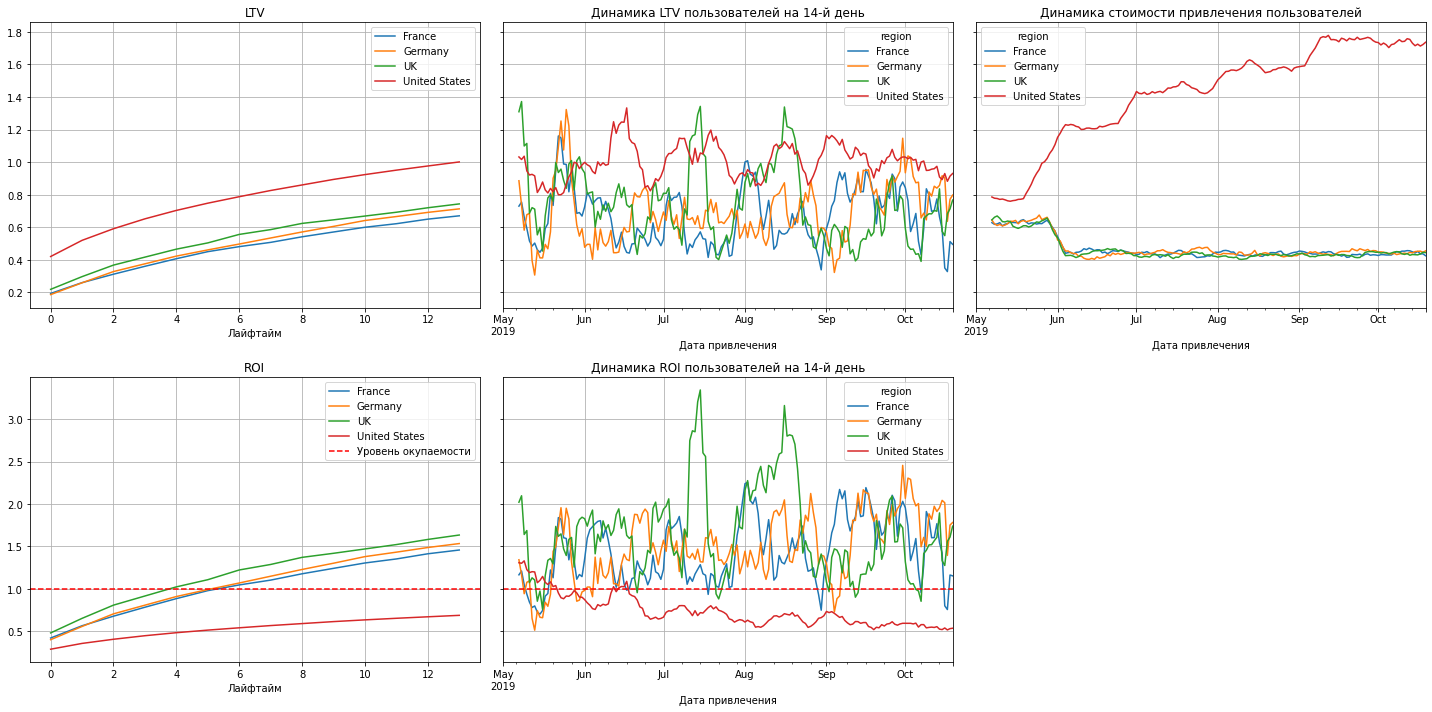

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

##### ВЫВОД

В разбивке по странам можно сделать следующие выводы:
- Реклама **не окупается** только в USA. Начиная с 7 дня рекалама окупается во всех старанх кроме USA.
- Стоимость привлечения стабильно растет только в USA. Для остальных стран в конце мая было резкое снижение стоимости привлечения, а дальше все стабильно, почти без изменений.
- LTV лучше всего по стране USA.
- Начиная с середины мая реклама в USA **не окупается**. По остальным странам реклама в общем окупается.

**Возможно дело в том, сколько тратят на рекламу в USA**

#### Анализ окупаемости рекламы с разбивкой по рекламным каналам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['channel'])

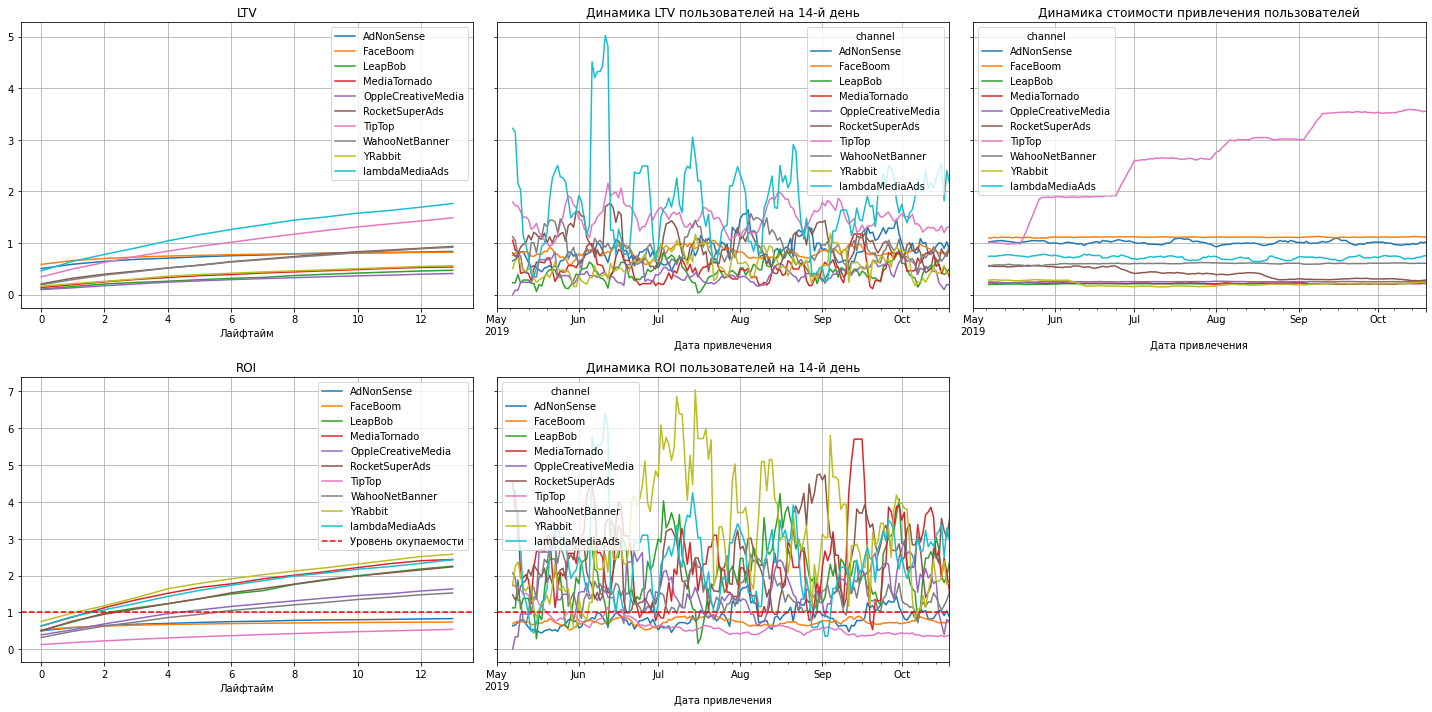

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Для удобства расшифровки графиков разделим рекламные каналы на две группы

In [ ]:
ch1 = profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost').head(5).index

In [ ]:
ch2 = profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost').tail(5).index

In [ ]:
profiles1 = profiles.query('channel in @ch1')

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles1, orders, observation_date, horizon_days, dimensions=['channel'])

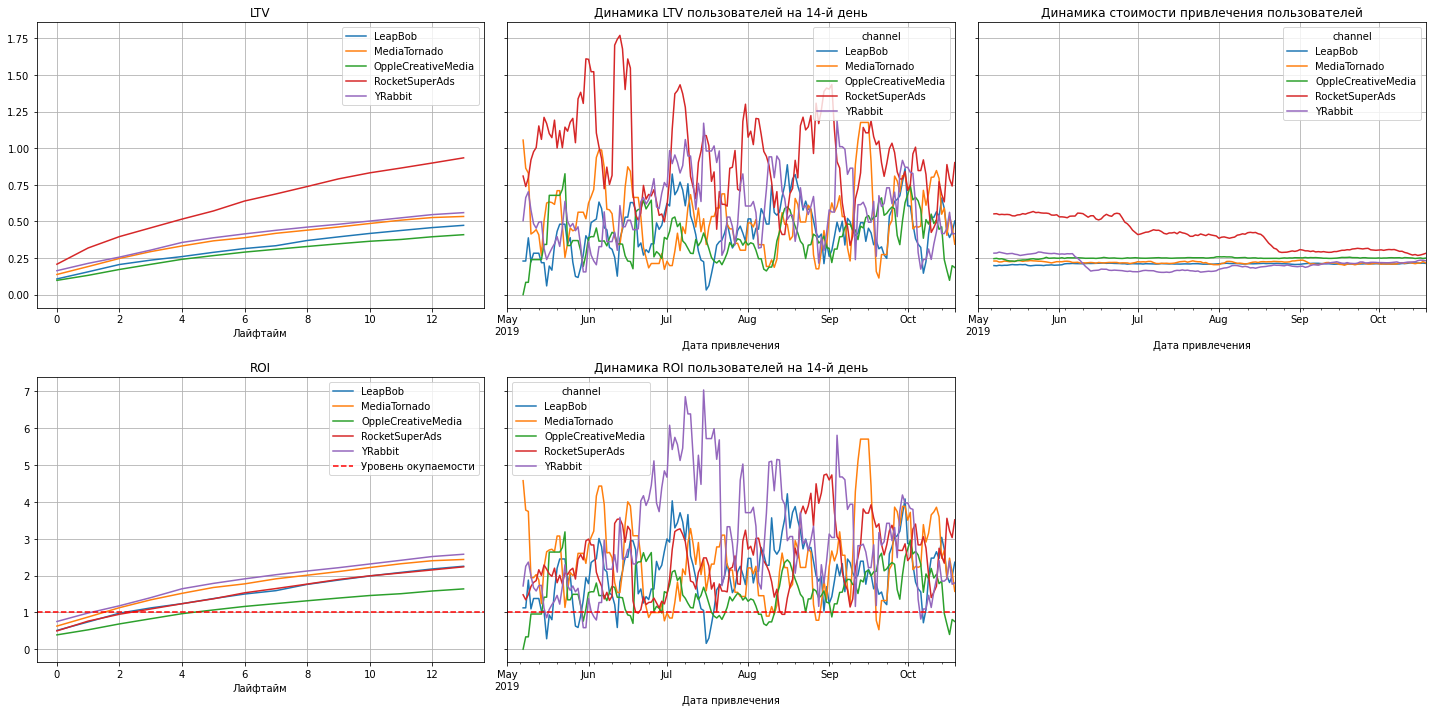

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

In [ ]:
profiles2 = profiles.query('channel in @ch2')

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles2, orders, observation_date, horizon_days, dimensions=['channel'])

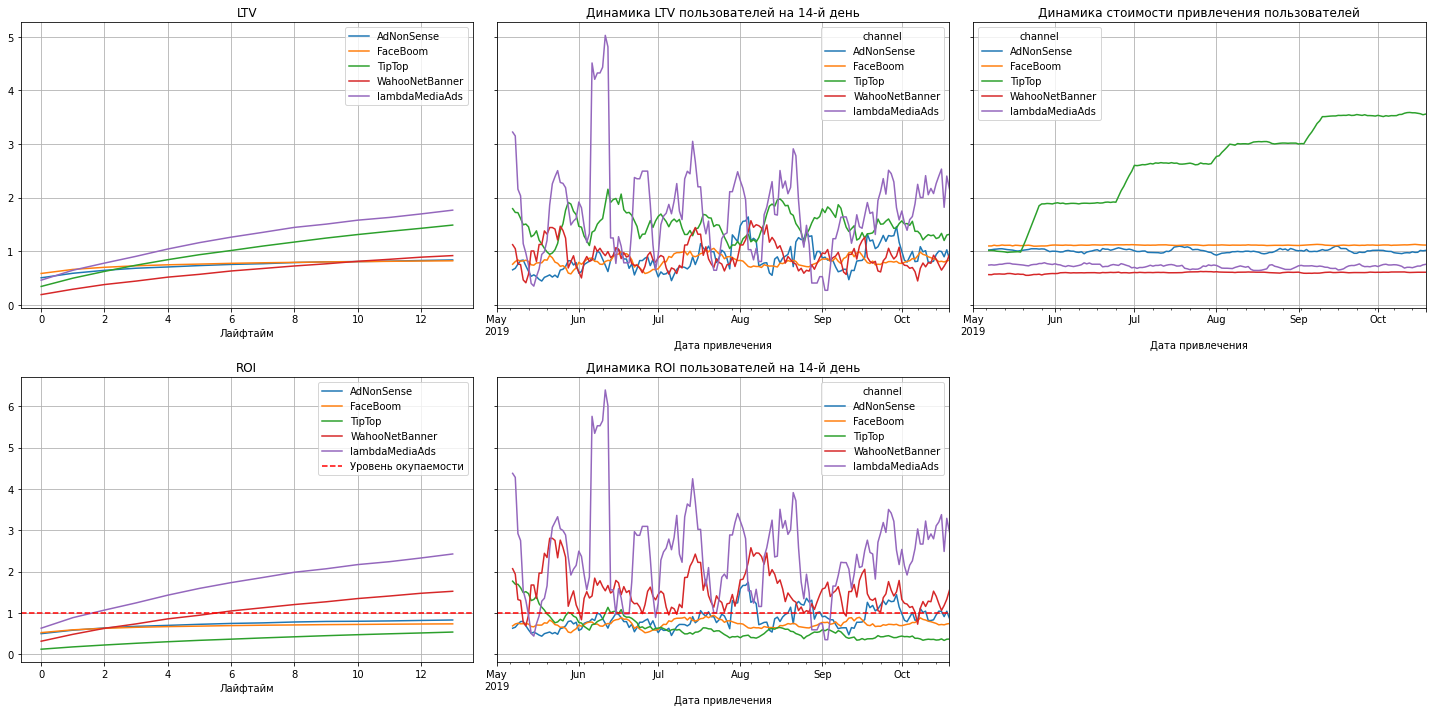

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

##### ВЫВОД

В разбивке по рекламным каналам можно сделать следующие выводы:
- Реклама **не окупается** только по каналам: `TipTop`, `AdNonSense` и `FaceBoom`.
- Стоимость привлечения стабильно растет в канале `TipTop`. Для остальных каналов стоимость почти без изменений или снижается.
- LTV лучше всего в канале `lambdaMediaAds` и `TipTop`.

#### Гипотезы и их проверка

Из представленныз выше графиков видим следующие проблемы:
- Пользователи из `USA` не окупаеются. Рост расходов на рекламу в `USA` связано с ростом расходов на рекламу по каналу `TipTop`
- Рекламный канал `TipTop` не окупается по причине увеличения вложения денег в рекламу по данному каналу, без увеличения притока платящих клиентов
- Рекламные каналы `AdNonSense` и `FaceBoom` могут не окупаться по причине плохого удержания


##### Гипотеза 1. Пользователи из `USA` не окупаеются и рост расходов на рекламу в `USA` связано с ростом расходов на рекламу по каналу `TipTop`

In [ ]:
profiles_h1 = profiles.query('region == "United States"')

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_h1, 
    orders,
    observation_date,
    horizon_days,
    dimensions=['region', 'channel'])

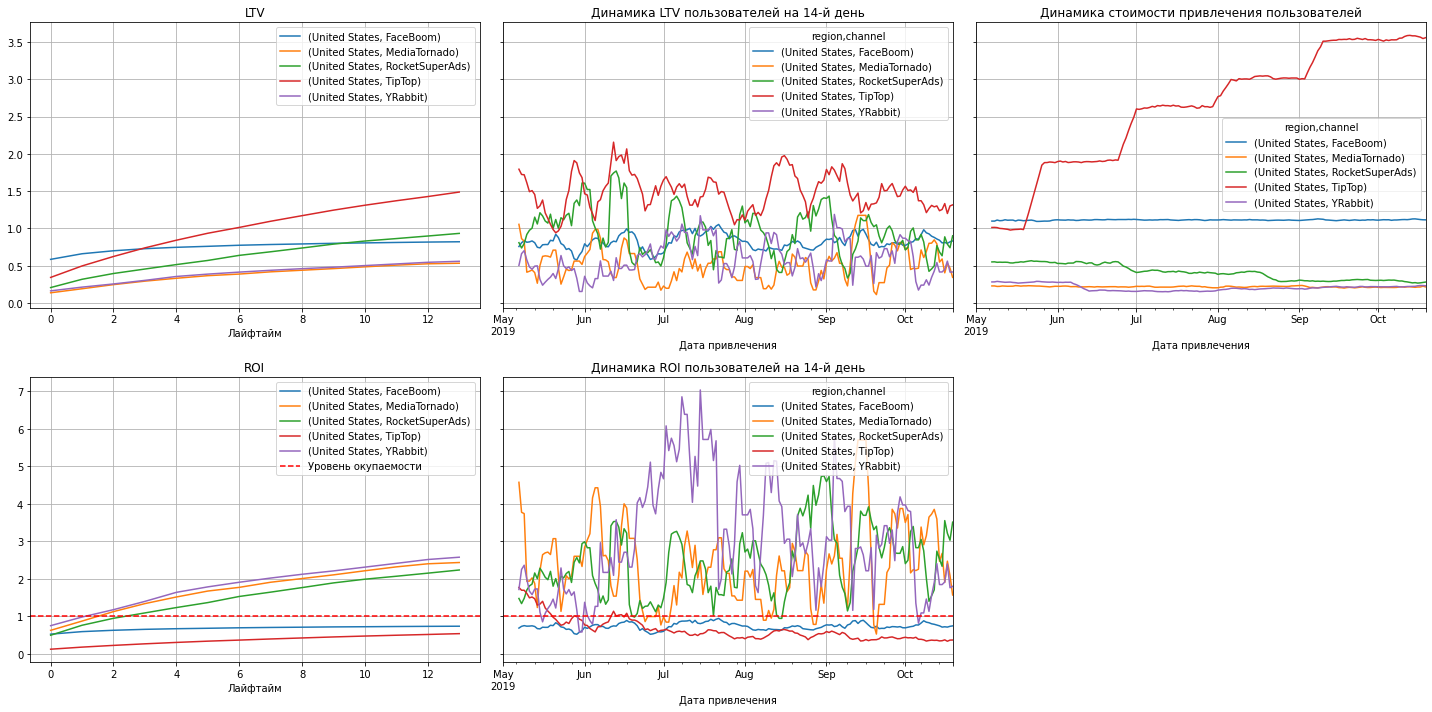

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

In [ ]:
usa_ch = profiles.query('region == "United States"')['channel'].unique()

In [ ]:
profiles.query('channel in @usa_ch').groupby(['region', 'channel']).agg({'acquisition_cost': 'mean'})

acquisition_cost
region        channel                         
United States FaceBoom                1.113286
              MediaTornado            0.218717
              RocketSuperAds          0.412095
              TipTop                  2.799003
              YRabbit                 0.218975

ВЫВОД

На основании данных представленных выше, по региону USA, можно сказать, что:
- не окупаются два рекламных канала TipTop и FaceBoom
- стоимость привлечения растет только по каналу TipTop

**Следовательно рост стоимости привлечения клиентов в стране USA связан с ростом по каналу TipTop (Данный канал привлекает клиентов только в USA)**

##### Гипотеза 2. Рекламный канал `TipTop` не окупается по причине увеличения вложения денег в рекламу по данному каналу, без увеличения притока платящих клиентов

In [ ]:
profiles.query('channel == "TipTop"').groupby(['month', 'payer']).agg({'user_id': 'nunique', 'acquisition_cost': 'mean'})

user_id  acquisition_cost
month      payer                           
2019-05-01 False     1992          1.358142
           True       204          1.350883
2019-06-01 False     2877          2.075895
           True       336          2.093005
2019-07-01 False     2875          2.650543
           True       298          2.650635
2019-08-01 False     3353          3.010888
           True       367          3.014962
2019-09-01 False     3434          3.481758
           True       368          3.467778
2019-10-01 False     3152          3.543565
           True       305          3.543224

###### ВЫВОД

Из таблицы выше видно, что расходы на привлечения одного пользователя выросли в 2,6 раз, а стабильного роста в платящих клиентов нет. В октябре их количество больше в 1,5 раза чем в мае.

##### Гипотеза 3. Рекламные каналы `AdNonSense` и `FaceBoom` могут не окупаться по причине плохого удержания

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    
)

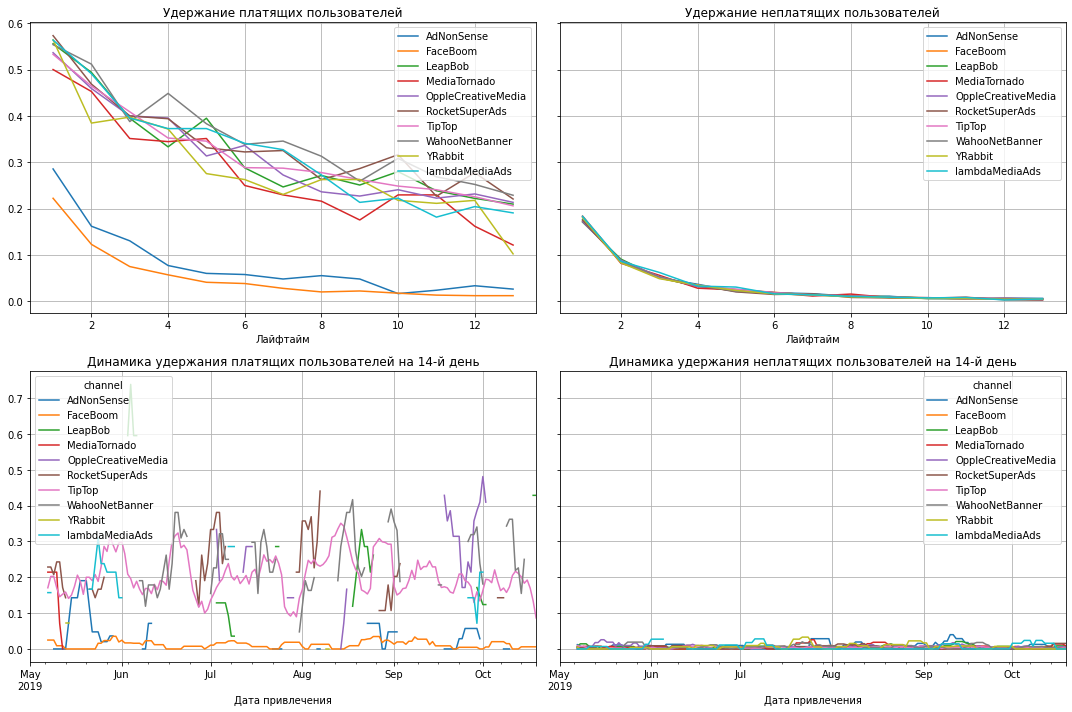

In [ ]:
plot_retention(retention, retention_history, horizon_days, window=7)

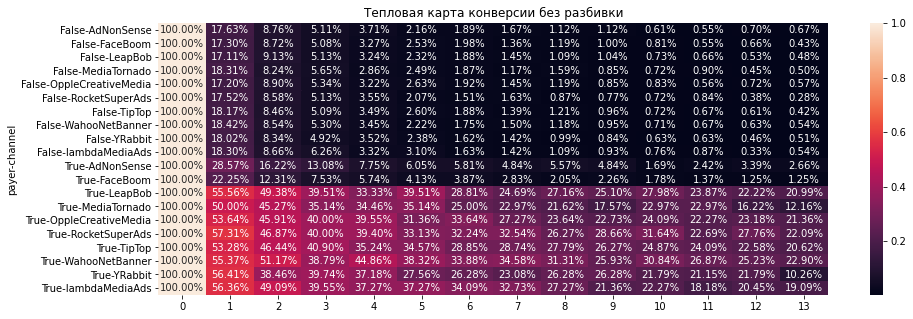

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(retention.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии без разбивки')
plt.show() 

##### ВЫВОД

По сравнению с другими каналами, видно, что у каналов `AdNonSense` и `FaceBoom` очень плохое удержание платящих клиентов. Начиная со второго дня оно уже хуже почти в два раза, нежели по остальным каналам. На четырнадцатый день хуже в 10 - 16 раз.

#### ВЫВОД

- Реклама, направленная на привлечение пользователей в целом **не окупается**;
- Негативное влияние на окупаемость рекламы оказывают следующие факторы:
    - Не окупаемостью рекламных каналов `TipTop` и `FaceBoom`
    - Постоянным ростом стоимости привлечения клиентов по каналу `TipTop`
    - Ужасное удержание по каналам `AdNonSense` и `FaceBoom`

Если убирать из анализа данные канала, то окупаемость рекламы будет по всем остальным каналам, странам и устройствам. 

Чем могут быть вызваны проблемы окупаемости:
- Качеством привлеченных пользователей или касетвом проведения привлечения пользователей по каналам `AdNonSense` и `FaceBoom`. (Может быть пользователей привлекали большими скидками на первую покупку);
- Кратно выросшим объемом затрат на привлечение пользователей по каналу `TipTop` без сильного увеличения притока платных клиентов по данному каналу.

**Рекомендации:**
- провести оценку роста стоимости привлечения клиентов по каналу `TipTop`
- выяснить причину почему удержание пользователей привлеченных по каналам `AdNonSense` и `FaceBoom` сильно хуже, чем по остальным каналам